In [2]:
outdir = snakemake.params.outdir
clone_var_dirs = snakemake.params.clone_var 
clcounts_dirs = snakemake.params.clcounts
dendro_dirs = snakemake.params.dendro 
vaf_dirs = snakemake.params.vaf

is_clonevar = snakemake.params.get("is_clonevar", True)
# output
# outdir = "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04/results/enriched_barcodes"

# ## Setup input directories
# n_donors = {
#     "chip_b1": 2,
#     "chip_b2": 2,
#     "chip_a1": 5,
#     "cd34":4
# }

# clone_var_donor_dirs = {
#     "chip_b1": "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_high_cells/clones/variants_init/knn/kparam_30",
#     "chip_b2": "/data/Mito_Trace/output/pipeline/v04/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_high_cells/clones/variants_init/knn/kparam_30/",
#     "chip_a1": "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_high_cells/clones/variants_init/knn/kparam_30",
#     "cd34": "/data/Mito_Trace/output/pipeline/v04/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_high_cells/clones/variants_init/knn/kparam_30"
# }


# # VAF and clone combine
# method_type = "clonalShift_method_clones/top"

# variants = "init"
# kparam = 30

# cloneMethod = f"cloneMethod_variants_{variants}_knn_resolution_{kparam}"

# vaf_donor_dirs = {
#     "chip_b1": "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_high_cells/repr_clones/",
#     "chip_b2": "/data/Mito_Trace/output/pipeline/v04/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_high_cells/repr_clones/",
#     "chip_a1": "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_high_cells/repr_clones",
#     "cd34": "/data/Mito_Trace/output/pipeline/v04/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_high_cells/repr_clones"
# }

overwrite=False

In [7]:
tmp_f = "/data/Mito_Trace/data/processed/figures/empty.svg"

In [2]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import mplh.fig_utils as fu
import numpy as np
import os
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom

import pandas as pd
import seaborn as sns
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

from svgutils.compose import *


import svgutils.transform as sg
import sys 

fig_utils from mplh


In [5]:
from src.config import ROOT_DIR

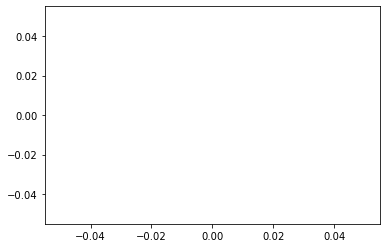

In [6]:
f, ax = plt.subplots()
plt.plot()
plt.savefig(join(ROOT_DIR, "data/processed/figures/empty.svg"))

In [4]:

"""
based on https://neuroscience.telenczuk.pl/?p=331
"""

import svgutils.transform as sg


class Svg(object):
    "svg files with a data object (the svg), width, height and coordinates"

    def __init__(self, data, dim, coords, name, global_scale=0.5):
        self.data = data
        self.width = dim[0]*global_scale
        self.height = dim[1]*global_scale
        self.x = coords[0]
        self.y = coords[1]
        self.global_scale = global_scale
        self.name = name

    def scale_width_to_reference(self, reference_width):
        """Proportionally scale the image to a given width."""
        scalings_factor = reference_width / self.width
        self.data.moveto(0, 0)#, scale=scalings_factor)
        self.width = self.width * scalings_factor
        self.height = self.height * scalings_factor

    def scale_height_to_reference(self, reference_height):
        """Proportionally scale the image to a given height."""
        scalings_factor = reference_height / self.height
        self.data.moveto(0, 0)#, scale=scalings_factor)
        self.width = self.width * scalings_factor
        self.height = self.height * scalings_factor
        
    def scale_by_factor(self, scalings_factor):
        """Proportionally scale image by a scaling factor."""
        self.data.moveto(0, 0, scale=scalings_factor)
        self.width = self.width * scalings_factor
        self.height = self.height * scalings_factor

    def move(self, x, y):
        """Move the coordinates of an image."""
        self.data.moveto(x, y)
        self.x = x
        self.y = y


def get_size(svg_file):
    """Naively parse the svg text file to get the width and height."""
    with open(svg_file) as svg:
        for line in svg:
            if line.startswith('<svg'):
                paramdict = {e.split('="')[0]: e.split('="')[1] for e in line[5:-2].split('" ')}
                break
    print(paramdict["width"])
    print("height")
    print(paramdict["height"])
    return int(np.ceil(float(paramdict["width"].replace('pt', '').replace('"', '')))), int(np.ceil(float(paramdict["height"].replace('pt', '').replace('"', ''))))



def rescale_height(svgs, curr_keys, ref_key):
    """Change the dimensions of the images to the desired combinations."""
    for key in curr_keys:
        svgs[key].scale_height_to_reference(svgs[ref_key].height)
    #assert svgs[ref_key].height == svgs[curr_keys[0]].height == svgs[curr_keys[-1]].height


def rescale_width(svgs, curr_keys, ref_key):
    """Change the dimensions of the images to the desired combinations."""
    for key in curr_keys:
        svgs[key].scale_width_to_reference(svgs[ref_key].width)
    #assert svgs[ref_key].height == svgs[curr_keys[0]].height == svgs[curr_keys[-1]].height


def change_positions(df, svgs, widths, heights):
    """Move the images to the desired positions."""
    for i_row, row in enumerate(df.index):
        for i_col, col in enumerate(df.columns):
            curr = df.loc[row, col].split(".svg")[0]
            svgs[curr].move(sum(widths[:i_col]), sum(heights[:i_row]))
    

def letter_annotations(svgs, df=None, only_grid_titles=True, figure_names=None, transposed=False):
    if only_grid_titles:
        all_texts = []
        if transposed: # make donors the columns and figure_names the rows
            for ind in df.index:
                nm = figure_names[ind]
                value = svgs[df.loc[ind].iloc[0].split(".svg")[0]]
                all_texts.append(sg.TextElement(value.x, value.y-10, nm, size=15, weight="bold")) 
            for col in df.columns:
                value = svgs[df[col].iloc[0].split(".svg")[0]]
                all_texts.append(sg.TextElement(value.x, value.y-10, col, size=15, weight="bold"))
                
        else:
            for ind in df.index:
                value = svgs[df.loc[ind].iloc[0].split(".svg")[0]]
                all_texts.append(sg.TextElement(value.x, value.y, ind, size=15, weight="bold"))
            for col in df.columns:
                nm = figure_names[col]
                value = svgs[df[col].iloc[0].split(".svg")[0]]
                all_texts.append(sg.TextElement(value.x, value.y-10, nm, size=15, weight="bold"))    
        return all_texts
    """Add letters based on the location of the images."""
    return [sg.TextElement(value.x, value.y, value.name, size=15, weight="bold")
            for key, value in svgs.items()]
#     return [sg.TextElement(value.x + 10, value.y + 15, value.name, size=15, weight="bold")
#             for key, value in svgs.items()]


def files_to_svg_dict(df, scale=0.5, verbose=False):
    """Convert a list of images to a dictionary.
    Mapping the image basename to the Svg class instance,
    setting the dimensions based on sizes and coordinates (0,0) by default
    """
    out = {}
    for row in df.index:
        for col in df.columns:
            s = df.loc[row, col]
            key = df.loc[row, col].split(".svg")[0]
            name = f"{row} {col.replace('dendro', '').replace('.svg', '')}"
            if verbose:
                print(s)
            if not exists(s):
                s = tmp_f
            out[key] = Svg(
                data=sg.fromfile(s).getroot().scale(scale),
                dim=get_size(s),
                coords=(0, 0),
                global_scale=scale,
                name=name)

                
    return out




def main_df(df, out_f, scale=0.25, figure_names=None, to_pdf=False):
    svgs = files_to_svg_dict(df, scale=scale)#df.values().flatten())
    
    for don, val in df.iterrows():
        curr_init_files = []
        curr_ref = val.iloc[0].split('.svg')[0] #svgs[val.iloc[0].split('.svg')[0]]
        curr_keys = [x.split('.svg')[0] for x in val.values] 
        rescale_height(svgs, curr_keys, curr_ref)
    
    col_max_widths = []

    for col in df.columns:
        curr_col_max = 0
        for ind in df.index:
            tmp_width = svgs[df.loc[ind, col].split(".svg")[0]].width
            if tmp_width > curr_col_max:
                curr_col_max = tmp_width
        col_max_widths.append(curr_col_max)

    row_max_heights = [] #should be the same in theory  
    for ind in df.index:
        curr_row_max = 0
        for col in df.columns:
            tmp_height = svgs[df.loc[ind, col].split(".svg")[0]].height
            if tmp_height > curr_row_max:
                curr_row_max = tmp_height
        row_max_heights.append(curr_row_max)
    
    change_positions(df, svgs, col_max_widths, row_max_heights)
    
    full_width = sum(col_max_widths) #[svgs[i].width for i in ['A', 'E']])
    full_height = sum(row_max_heights) #[svgs[i].height for i in ['A', 'B', 'C', 'D']])
    fig = sg.SVGFigure(full_width+20, full_height+20)
    text = letter_annotations(svgs, df=df, figure_names=figure_names)
    fig.append([s.data for s in svgs.values()])
    fig.append(text)
    fig.save(out_f)
 
    cmd = f'inkscape --file={out_f} -d 300 --export-area-drawing --without-gui --export-png={out_f.replace(".svg", ".png")}' # --export-area-drawing --without-gui --export-pdf=output.pdf'
    print(cmd)
    !{cmd}
    
    if to_pdf:
        cmd = f'inkscape --file={out_f} --export-area-drawing --without-gui --export-pdf={out_f.replace("svg", "pdf")} '
        print(cmd)
        !{cmd}
    
    

def main_df_transpose(df, out_f, scale=0.25, figure_names=None, to_pdf=False, to_transpose=True):
    
    svgs = files_to_svg_dict(df, scale=scale)#df.values().flatten())
    
    df = df.transpose()
    for don, val in df.iterrows():
        curr_init_files = []
        tmp = 0
        loop = True
        while loop and tmp <= len(val):
            if val.iloc[tmp] is not None:
                loop = False
            tmp += 1
        curr_ref = val.iloc[tmp].split('.svg')[0] #svgs[val.iloc[0].split('.svg')[0]]
        curr_keys = [x.split('.svg')[0] for x in val.values] 
        rescale_width(svgs, curr_keys, curr_ref)
    
    col_max_widths = []
    for col in df.columns:
        curr_col_max = 0
        for ind in df.index:
            if df.loc[ind,col] is not None:
                tmp_width = svgs[df.loc[ind, col].split(".svg")[0]].width
                if tmp_width > curr_col_max:
                    curr_col_max = tmp_width
        col_max_widths.append(curr_col_max)

    row_max_heights = [] #should be the same in theory  
    for ind in df.index:
        curr_row_max = 0
        for col in df.columns:
            tmp_height = svgs[df.loc[ind, col].split(".svg")[0]].height
            if tmp_height > curr_row_max:
                curr_row_max = tmp_height
        row_max_heights.append(curr_row_max)
    
    change_positions(df, svgs, col_max_widths, row_max_heights)
    
    full_width = sum(col_max_widths) #[svgs[i].width for i in ['A', 'E']])
    full_height = sum(row_max_heights) #[svgs[i].height for i in ['A', 'B', 'C', 'D']])
    fig = sg.SVGFigure(full_width+20, full_height+20)
    text = letter_annotations(svgs, df=df, figure_names=figure_names, transposed=True)
    fig.append([s.data for s in svgs.values()])
    fig.append(text)
    fig.save(out_f)
 
    cmd = f'inkscape --file={out_f} -d 300 --export-area-drawing --without-gui --export-png={out_f.replace(".svg", ".png")}' # --export-area-drawing --without-gui --export-pdf=output.pdf'
    print(cmd)
    !{cmd}
    
    if to_pdf:
        cmd = f'inkscape --file={out_f} --export-area-drawing --without-gui --export-pdf={out_f.replace("svg", "pdf")} '
        print(cmd)
        !{cmd}
    


In [5]:
#"single_clones/donor0/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/top/"

# 4. Variants concat

In [ ]:
# vaf_figure_names =  {
#     "all_variants_af.svg":"vaf",
#     "all_variants_distinct_pct_vs_other.svg": "barcode pct in clone"
# }
vaf_figure_names =  {
    "all_variants_af.svg":"vaf",
    "all_variants_distinct_pct_vs_other.svg": "barcode pct in clone"
}

# fvars_pct = join(outdir, "top_variants_distinct_pct_vs_other.svg")
# fvars_pct_minus = join(outdir, "top_variants_pct_minus_other.svg")
# fvars_vars_af = join(outdir, "top_variants_af.svg")
# fvars_vars_af_box = join(outdir, "top_variants_in_clone_af_boxen.svg") 


vaf_subfig_df = pd.DataFrame(index=list(vaf_dirs.keys()),columns = list(vaf_figure_names.keys()))

for run in vaf_dirs:
    curr_dir = vaf_dirs[run]
    for f_name in vaf_subfig_df.columns:
        #print('curr_f', curr_f)
        curr_f = join(curr_dir, f_name)
        
        vaf_subfig_df.loc[run, f_name] = curr_f
        
        #assert(exists(curr_f))
vaf_subfig_df   

if overwrite or not exists(join(outdir, "vaf.svg")):
    main_df_transpose(vaf_subfig_df, join(outdir, "vaf.svg"), 
            scale=0.25, figure_names=vaf_figure_names)

# 1. clone_var supplementary

## Convert from pdf to svg 

In [6]:
# for run in clone_var_dirs:
#     for d in np.arange(n_donors[run]):
#         curr_pdfs = glob(join(clone_var_dirs[run], f"donor{d}",  "*.pdf"))
#         for in_f in curr_pdfs:
#         #in_f = join(clone_var_dirs, "best_params.pdf")
#             out_f = in_f.replace(".pdf", ".svg")
#             if not exists(out_f):
#                 cmd = f"inkscape -l {out_f} {in_f}" 
#                 print(cmd)
#                 !{cmd}
#             else:
#                 print(f"{out_f} already here")

## Loop through and align svgs, with each donor in horizontal

In [7]:
if is_clonevar:
    clonevar_figure_names = {
        "best_params.svg": "Final clone-barcode table",
        "top10perc_param_group_clusters.svg": "Cluster top hyperparameters by multi-objectives",
        "elbow_multi_obj_nclust.svg": "Elbow plot for determining number of objective clusters",
        "multi_clusters_nclust.svg": "multi_obj_clusters" ,
        "top_param_group_results.svg": "top_objective_scores"
        #"top_param_groups_clone_vars.svg": "clone-barcode table of top hyperparameter clusters",
    }

    #     "multi_clusters_nclust.svg": "Cluster hyperparameter and take highest objective score cluster",
    #     "top_param_group_results.svg": "Hyperparameter cluster objective results"
    # }

    # indexes = []
    # for run in clone_var_dirs:
    #     indexes.append(run)
    #     for d in np.arange(n_donors[run]):
    #         indexes.append(join(f"{run}_donor{d}"))

    don_row_subfig_col_df = pd.DataFrame(index=list(clone_var_dirs.keys()),columns = list(clonevar_figure_names.keys()))
    for run in clone_var_dirs:
        curr_dir = clone_var_dirs[run]
        for f_name in don_row_subfig_col_df.columns:
            curr_f = join(curr_dir, f_name)
            don_row_subfig_col_df.loc[run, f_name] = curr_f

    don_row_subfig_col_df


    if overwrite or not exists(join(outdir, "clone_var_supplementary.svg")):
        main_df(don_row_subfig_col_df, join(outdir, "clone_var_supplementary.svg"), 
                scale=0.25, figure_names=clonevar_figure_names)

# 2. Dendrograms: 

In [8]:
dendro_figure_names =  {"dendro.NoCondition.max2.AF.svg": "AF (max 0.2)",
             "dendro.NoCondition.max5.AF.svg": "AF (max 0.5)",
             "dendro.NoCondition.DP.svg": "Log2 reads per cell-MT position"}


In [14]:
dendro_don_subfig_df = pd.DataFrame(index=list(dendro_dirs.keys()),columns = ["dendro.NoCondition.max2.AF.svg",
                                                             "dendro.NoCondition.max5.AF.svg",
                                                             "dendro.NoCondition.DP.svg"]
                                   )

for run in dendro_dirs:
    curr_dendro_prefix = dendro_dirs[run] # full path prefix,  not a directory, so concat dir and file 
    for f_name in dendro_don_subfig_df.columns:
        curr_f = curr_dendro_prefix + f_name
        dendro_don_subfig_df.loc[run, f_name] = curr_f
        #assert(exists(curr_f))
        
# for run in clone_var_donor_dirs:
#     for d in np.arange(n_donors[run]):
#         curr_ind = f"{run}_donor{d}"
#         curr_dendro_prefix = join(clone_var_donor_dirs[run], "barcodes/btwnClones_dendro", f"donor{d}.")
#         for f_name in dendro_don_subfig_df.columns:
#             curr_f = curr_dendro_prefix + f_name
#             dendro_don_subfig_df.loc[curr_ind, f_name] = curr_f
#             assert(exists(curr_f))
dendro_don_subfig_df   

if overwrite or not exists(join(outdir, "dendrogram_barcodes.svg")):
    main_df(dendro_don_subfig_df, join(outdir, "dendrogram_barcodes.svg"), 
            scale=0.25, figure_names=dendro_figure_names)

# 3. Clone count barplots

In [15]:
cl_count_figure_names =  {
    "normalized_counts.barplot_conditions.svg": "normalized clone counts",
    "top20_minCell10_clone_counts.barplot_conditions.svg": "top 20 clones",
    "clone_counts.conditionScatter.svg": "scatterplot of ncells across conditions"
}

#    "clone barplot": "clone_counts.barplot_conditions.svg",

In [16]:
cl_count_subfig_df = pd.DataFrame(index=list(clcounts_dirs.keys()),
                                  columns = list(cl_count_figure_names.keys()))

for run in clcounts_dirs:
    curr_dir = clcounts_dirs[run]
    for f_name in cl_count_subfig_df.columns:
        curr_f = join(curr_dir, f_name)
        cl_count_subfig_df.loc[run, f_name] = curr_f
        #assert(exists(curr_f))
cl_count_subfig_df   

if overwrite or not exists(join(outdir, "clone_counts.svg")):
    main_df(cl_count_subfig_df, join(outdir, "clone_counts.svg"), 
            scale=0.5, figure_names=cl_count_figure_names)

## 5. Representative clones

In [ ]:
# # repr_figure_names =  {
# #     "all_variants_af.svg":"vaf",
# #     "all_variants_distinct_pct_vs_other.svg": "barcode pct in clone"
# # }


# vaf_subfig_df = pd.DataFrame(index=list(vaf_dirs.keys()),columns = list(vaf_figure_names.keys()))

# for run in vaf_dirs:
#     curr_dir = vaf_dirs[run]
#     for f_name in vaf_subfig_df.columns:
#         print('curr_f', curr_f)
#         curr_f = join(curr_dir, f_name)
#         vaf_subfig_df.loc[run, f_name] = curr_f
#         assert(exists(curr_f))
# vaf_subfig_df   

# if overwrite or not exists(join(outdir, "vaf.svg"))
#     main_df_transpose(vaf_subfig_df, join(outdir, "vaf.svg"), 
#             scale=0.25, figure_names=vaf_figure_names)

## Create Figure 2
(Need select variants)

## Create hyperparam clone-var supplementary